In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
import os
import datetime

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.features.soundlevel import soundlevel_for_file
from src.utils.fileutils import get_project_root


In [277]:
from src.data.annotations import load_dataset_annotations

annotations = load_dataset_annotations(datasets)
annotations

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping TUT_annotation_notes.md


start      end                 annotation  \
dataset clip             index                                                 
maestro metro_station_04 0        8.6037   10.701  Male speech, man speaking   
                         1       10.8350   11.065  Male speech, man speaking   
                         2       11.2530   11.594  Male speech, man speaking   
                         3       11.5730   11.688            Walk, footsteps   
                         4       11.7860   11.901            Walk, footsteps   
...                                  ...      ...                        ...   
tut     b093             120    207.6610  207.773            Walk, footsteps   
                         121    208.7350  208.848            Walk, footsteps   
                         122    209.2390  209.400            Walk, footsteps   
                         123    209.7410  209.843            Walk, footsteps   
                         124    210.2980  210.465            Walk, footsteps   

                               annotator  
dataset clip             index            
maestro metro_station_04 0            BD  
                         1            BD  
                         2            BD  
                         3            BD  
                         4            BD  
...                                  ...  
tut     b093             120          BD  
                         121          BD  
                         122          BD  
                         123          BD  
                         124          BD  

[1492 rows x 4 columns]

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


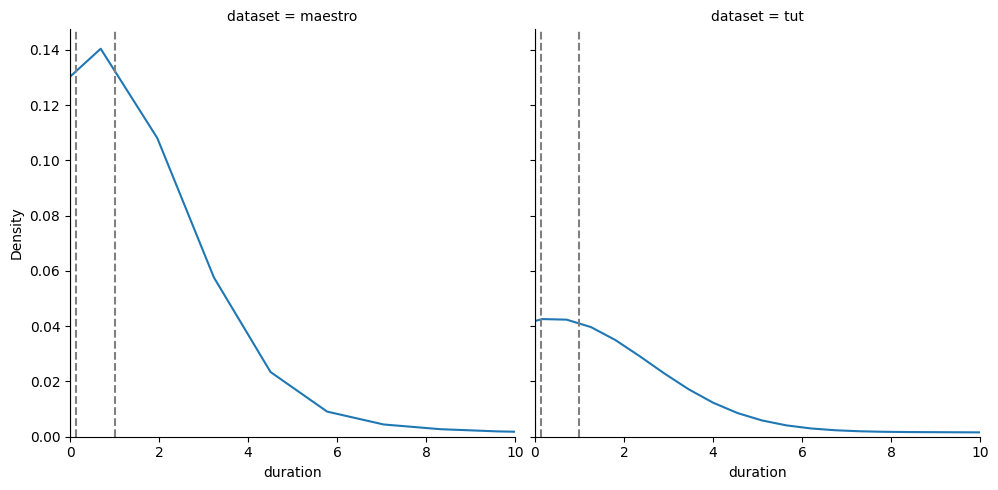

In [311]:

a = annotations.copy()
a['duration'] = a['end'] - a['start']

g = seaborn.displot(kind='kde', data=a.reset_index(), col='dataset', x='duration')

def set_references(g):
    g.refline(x=0, color='black', ls='-')
    g.refline(x=0.125, label='fast')
    g.refline(x=1.0, label='slow')
    g.set(xlim=(0, 10))

set_references(g)


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


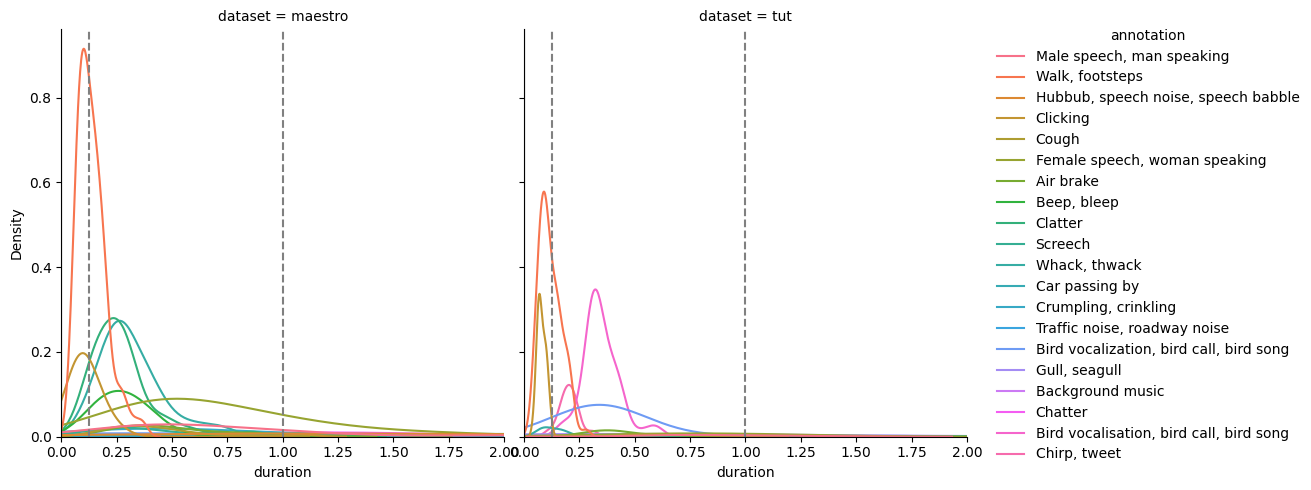

In [344]:

def plot_annotation_subset(a, annotation_names):

    l = a[a.annotation.isin(annotation_names)]
    g = seaborn.displot(kind='kde', data=l.reset_index(), col='dataset', hue='annotation', x='duration')

    set_references(g)
    g.set(xlim=(0, 2.0))
    #g.set(xscale='log')
    return g

most_frequent = annotations.annotation.value_counts().head(20).index
plot_annotation_subset(a, most_frequent)


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


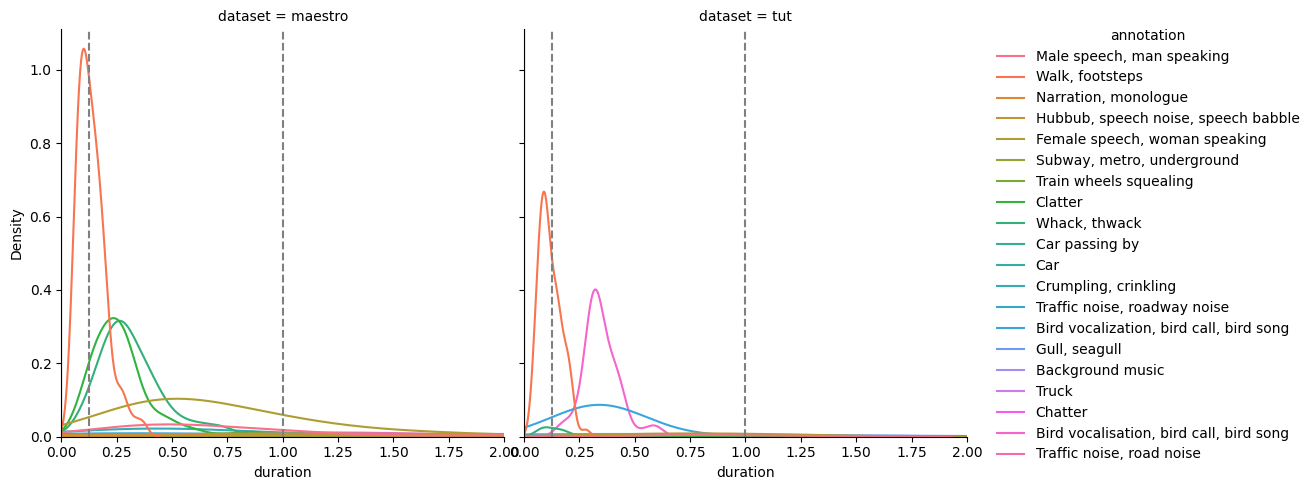

In [345]:

most_duration = a.groupby('annotation')['duration'].sum().sort_values(ascending=False).head(20)
#print(most_duration)

plot_annotation_subset(a, most_duration.index)


In [359]:
pandas.Series(a['duration'].quantile(0.90)).sort_values(ascending=False)

0    2.056826
dtype: float64

In [353]:

a.groupby('annotation')['duration'].quantile(0.90).sort_values(ascending=False)


annotation
Traffic noise, roadway noise    40.701826
Traffic noise, road noise       37.687124
Subway, metro, underground      25.271076
Truck                           11.658608
Car passing by                  10.044000
                                  ...    
Chip, tweet                      0.209000
Walk, footsteps                  0.204000
Clatter - Whack, thwack          0.186000
Clicking                         0.153591
Bass (frequency range)           0.092000
Name: duration, Length: 75, dtype: float64

In [409]:

def load_noise_classes():
    p = os.path.join(project_root, 'data/processed/noise_classes.csv')
    df = pandas.read_csv(p, sep=';', quotechar="'")
    df['noise'] = df.noise.fillna('other')
    df = df.set_index('original')
    return df

m = load_noise_classes()
m.noise.value_counts()

other           35
speech          16
road_traffic    11
biophony         5
geophony         4
rail_traffic     2
music            2
Name: noise, dtype: int64

In [427]:

from src.data.annotations import make_continious_labels

def plot_multitrack_labels(ax, labels : pandas.DataFrame, cmap='Purples', x_seconds=1):

    labels = labels.copy()

    # heatmap does not support Timedelta
    labels.index = labels.index / pandas.Timedelta(seconds=x_seconds)

    seaborn.heatmap(labels.T, ax=ax, annot=False, cmap=cmap)

def make_multitrack_labels(df, classes=None, time_resolution=0.100):
    last = df['end'].max()
    out = make_continious_labels(df, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)

    #fig, ax = plt.subplots(1, figsize=(10, 4))
    #plot_multitrack_labels(ax, out)
    
    return out

aa = annotations.copy()
aa['noise_class'] = aa.annotation.map(m.noise.to_dict())
all_classes = sorted(aa.noise_class.unique())
multi_track = aa.groupby(['dataset', 'clip']).apply(make_multitrack_labels, classes=all_classes)
multi_track

biophony  geophony  music  \
dataset clip               time                                                
maestro cafe_restaurant_08 0 days 00:00:00                0         0      0   
                           0 days 00:00:00.100000         0         0      0   
                           0 days 00:00:00.200000         0         0      0   
                           0 days 00:00:00.300000         0         0      0   
                           0 days 00:00:00.400000         0         0      0   
...                                                     ...       ...    ...   
tut     b093               0 days 00:03:30.400000         0         0      0   
                           0 days 00:03:30.500000         0         0      0   
                           0 days 00:03:30.600000         0         0      0   
                           0 days 00:03:30.700000         0         0      0   
                           0 days 00:03:30.800000         0         0      0   

                                                   other  rail_traffic  \
dataset clip               time                                          
maestro cafe_restaurant_08 0 days 00:00:00             0             0   
                           0 days 00:00:00.100000      0             0   
                           0 days 00:00:00.200000      0             0   
                           0 days 00:00:00.300000      0             0   
                           0 days 00:00:00.400000      0             0   
...                                                  ...           ...   
tut     b093               0 days 00:03:30.400000      1             0   
                           0 days 00:03:30.500000      0             0   
                           0 days 00:03:30.600000      0             0   
                           0 days 00:03:30.700000      0             0   
                           0 days 00:03:30.800000      0             0   

                                                   road_traffic  speech  
dataset clip               time                                          
maestro cafe_restaurant_08 0 days 00:00:00                    0       0  
                           0 days 00:00:00.100000             0       0  
                           0 days 00:00:00.200000             0       0  
                           0 days 00:00:00.300000             0       0  
                           0 days 00:00:00.400000             0       0  
...                                                         ...     ...  
tut     b093               0 days 00:03:30.400000             1       0  
                           0 days 00:03:30.500000             1       0  
                           0 days 00:03:30.600000             1       0  
                           0 days 00:03:30.700000             1       0  
                           0 days 00:03:30.800000             1       0  

[34998 rows x 7 columns]

In [426]:

def single_track_labels(multi : pandas.DataFrame, mixed_class='mixed'):

    classes_active = multi.sum(axis=1)
    out = pandas.Series(['background']*len(multi), index=multi.index, dtype=pandas.StringDtype())

    # Simple definition of mixed: anytime there is any form of overlap in the labels
    out.loc[classes_active == 2] = 'mixed'
    
    out.loc[classes_active == 1] = multi.idxmax(axis=1)
    return out


single_track = multi_track.groupby(['dataset', 'clip'], group_keys=False).apply(single_track_labels)
single_track

dataset  clip                time                  
maestro  cafe_restaurant_08  0 days 00:00:00             background
                             0 days 00:00:00.100000      background
                             0 days 00:00:00.200000      background
                             0 days 00:00:00.300000      background
                             0 days 00:00:00.400000      background
                                                           ...     
tut      b093                0 days 00:03:30.400000           mixed
                             0 days 00:03:30.500000    road_traffic
                             0 days 00:03:30.600000    road_traffic
                             0 days 00:03:30.700000    road_traffic
                             0 days 00:03:30.800000    road_traffic
Length: 34998, dtype: string

dataset  clip               
maestro  cafe_restaurant_08     None
         cafe_restaurant_10     None
         city_center_09         None
         city_center_11         None
         grocery_store_02       None
         grocery_store_08       None
         metro_station_04       None
         metro_station_05       None
         residential_area_06    None
         residential_area_12    None
tut      a003                   None
         a008                   None
         b005                   None
         b091                   None
         b093                   None
dtype: object

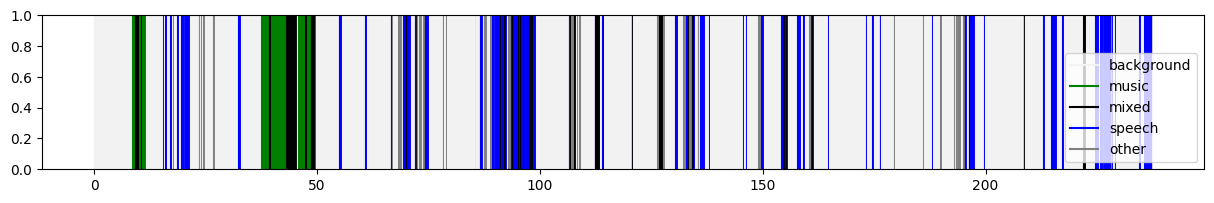

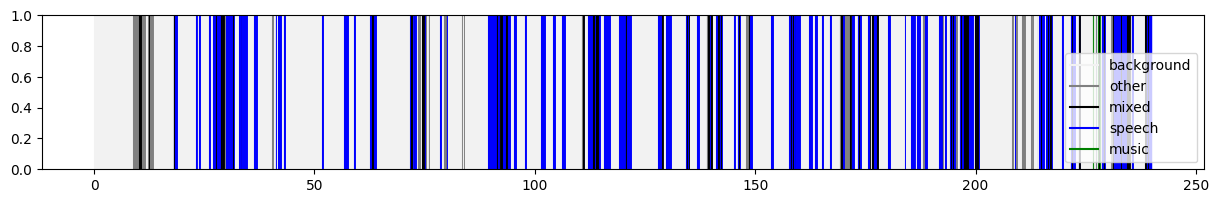

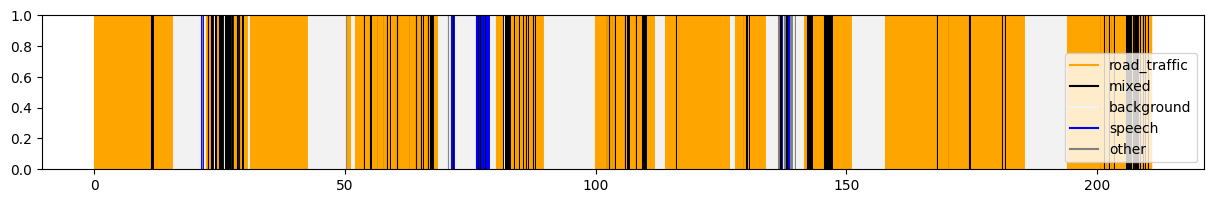

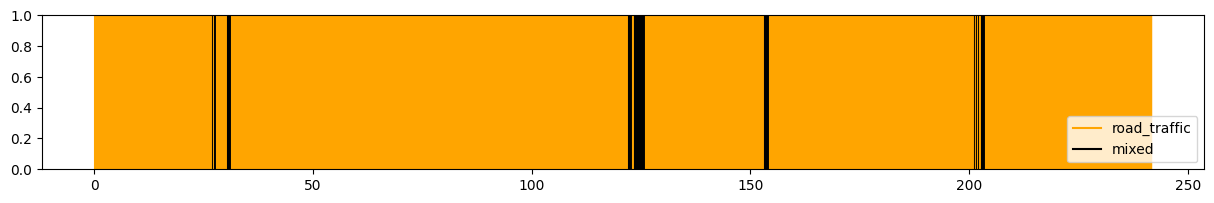

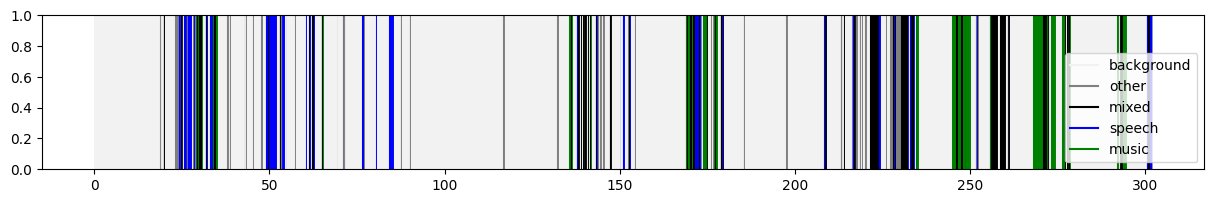

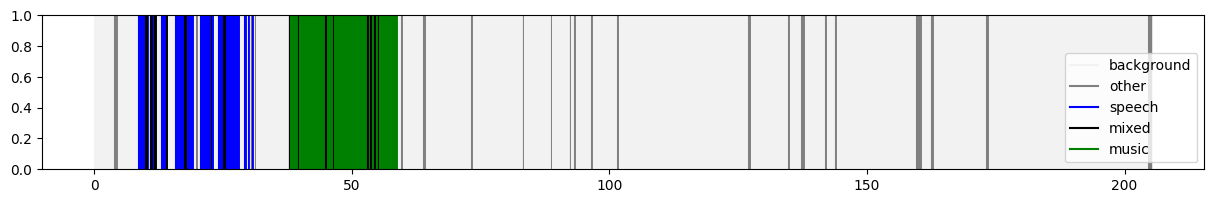

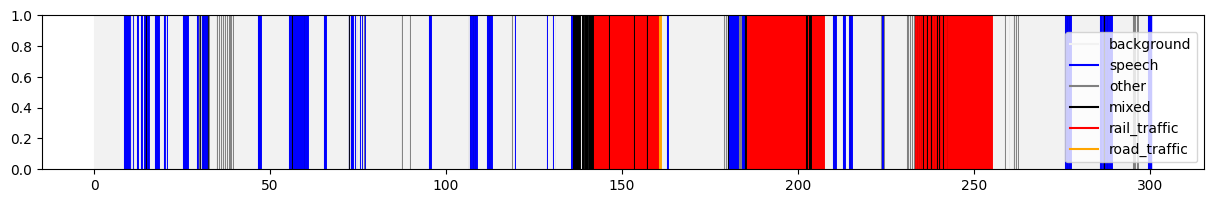

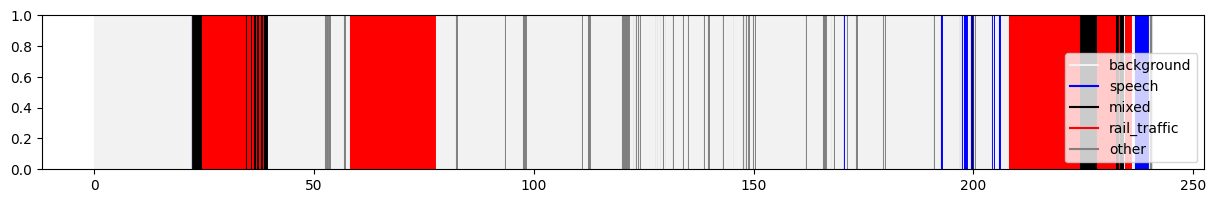

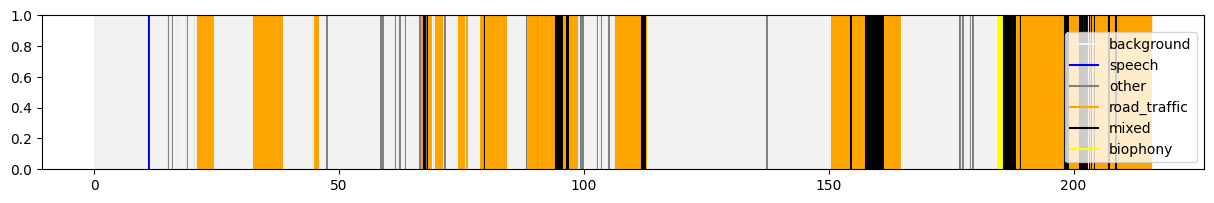

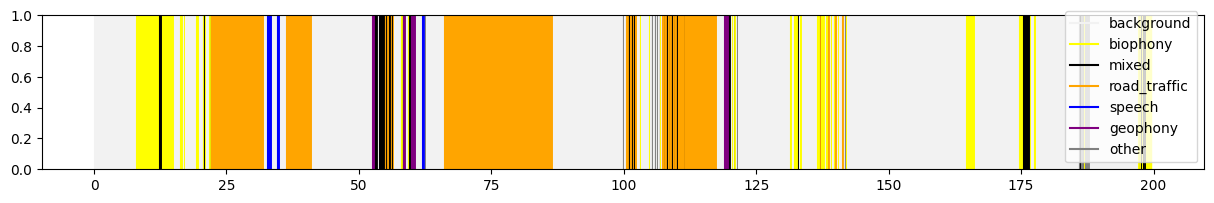

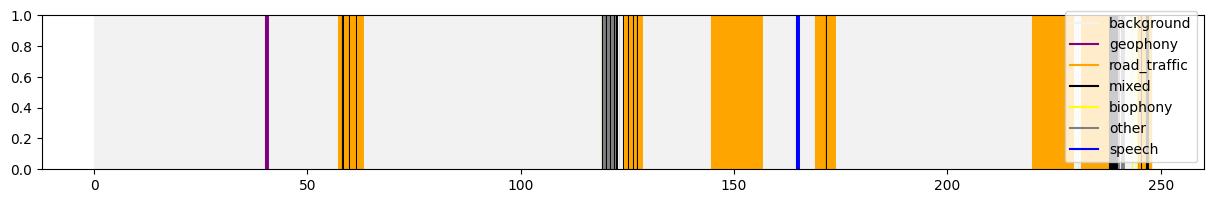

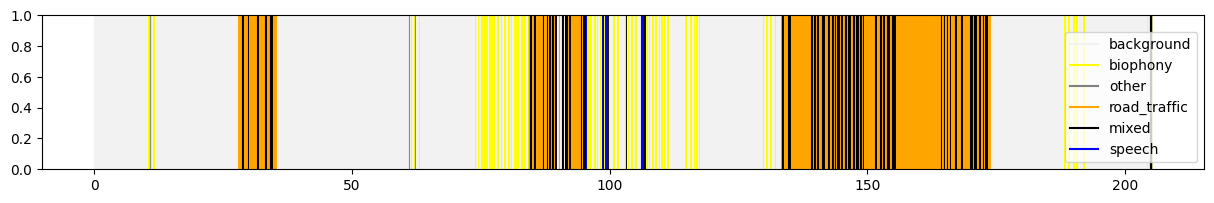

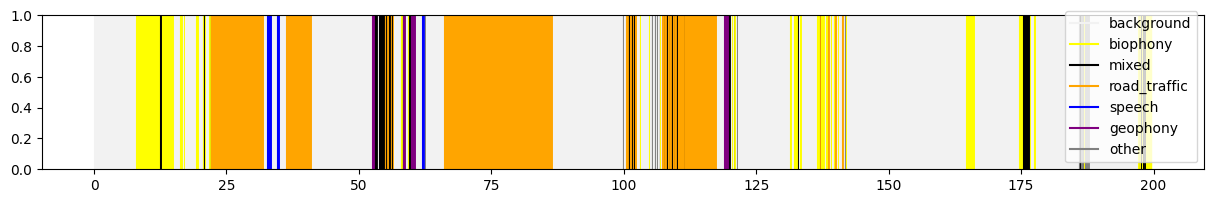

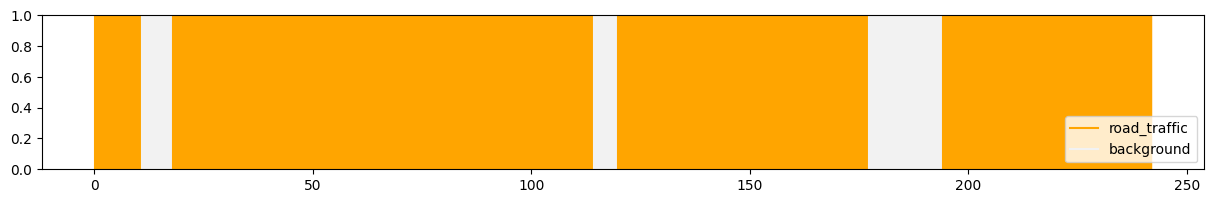

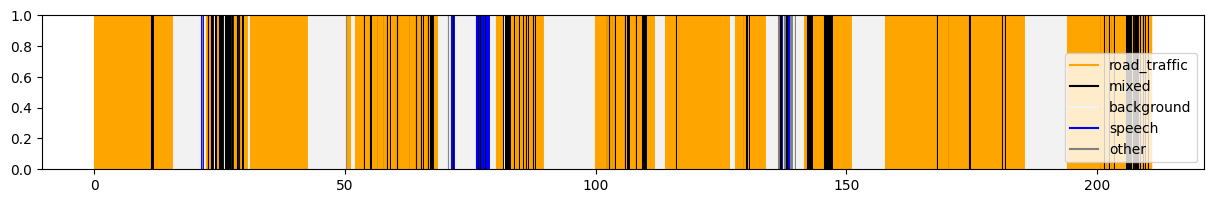

In [484]:

#def plot_single_track(ax, single : pandas.DataFrame):

def dense_to_events(df : pandas.DataFrame,
                    category_column='label',
                    time_column='time',
                   ) -> pandas.DataFrame:
    """
    Convert a dense time-series with categories into events with start,end
    """
    df = df.copy() # avoid mutating input
    df['start'] = df[time_column]
    df['end'] = df[time_column]
    changes = df[category_column].ne(df[category_column].shift()).dropna()
    label_groups = changes.cumsum()

    out = df.groupby(label_groups).agg({'start':'min', 'end':'max', category_column:'first'}).reset_index(drop=True)

    return out

from src.visualization.events import plot_events

class_color_map = {
    'background': (0.95, 0.95, 0.95),
    'mixed': 'black',
    'speech': 'blue',
    'music': 'green',
    'rail_traffic': 'red',
    'road_traffic': 'orange',
    'other': 'grey',
    'biophony': 'yellow',
    'geophony': 'purple',
}

def plot(s):

    fig, ax = plt.subplots(1, figsize=(15, 2))

    # A) convert back to indicator columns. Use existing multi track plotting
    # will make switches clear - but not obvious that the classes are mutually exclusive
    multi = pandas.get_dummies(s)
    multi = multi.reset_index().set_index('time').drop(columns=['dataset', 'clip'])    
    #plot_multitrack_labels(ax, multi)


    # B) group into runs. Use vspan to plot colored sections
    df = s.to_frame()
    df.columns = ['label']
    df = df.reset_index()
    df['time'] = df.time / pandas.Timedelta(seconds=1) # matplotlib / plot_events() does not like Timedeltas
    df = df.drop(columns=['dataset', 'clip'])

    cons = dense_to_events(df)
    cons['color'] = cons.label.map(class_color_map)
    
    plot_events(ax, cons, color='color', label='label', alpha=1.0)
    legend_without_duplicate_labels(ax)
    

single_track.groupby(['dataset', 'clip']).apply(plot)


In [399]:
annotations.annotation.map(m.noise.to_dict()).value_counts()

other           780
speech          318
biophony        196
road_traffic    145
music            23
geophony         20
rail_traffic     10
Name: annotation, dtype: int64

other           35
speech          16
road_traffic    11
biophony         5
geophony         4
rail_traffic     2
music            2
Name: noise, dtype: int64

In [396]:
m[m.noise == 'other']

,noise
original,
"Walk, footsteps",other
"Slap, smack",other
Clicking,other
Other sourceless,other
Scrape,other
Clickety-clack,other
"Beep, bleep",other
Clatter,other
Brief tone,other


In [298]:
# Load from files
soundlevels = pandas.read_parquet(os.path.join(project_root, 'data/processed/soundlevels/LAS.parquet'))
soundlevels


level
config dataset clip             time                             
LAS    maestro metro_station_04 0 days 00:00:00        -76.099976
                                0 days 00:00:00.250000 -75.837673
                                0 days 00:00:00.500000 -75.996588
                                0 days 00:00:00.750000 -75.938581
                                0 days 00:00:01        -76.228364
...                                                           ...
       tut     b093             0 days 00:03:29.500000 -53.015915
                                0 days 00:03:29.750000 -53.112149
                                0 days 00:03:30        -53.103120
                                0 days 00:03:30.250000 -53.007961
                                0 days 00:03:30.500000 -52.817005

[14056 rows x 1 columns]

Index(['config', 'dataset', 'clip', 'time', 'level'], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


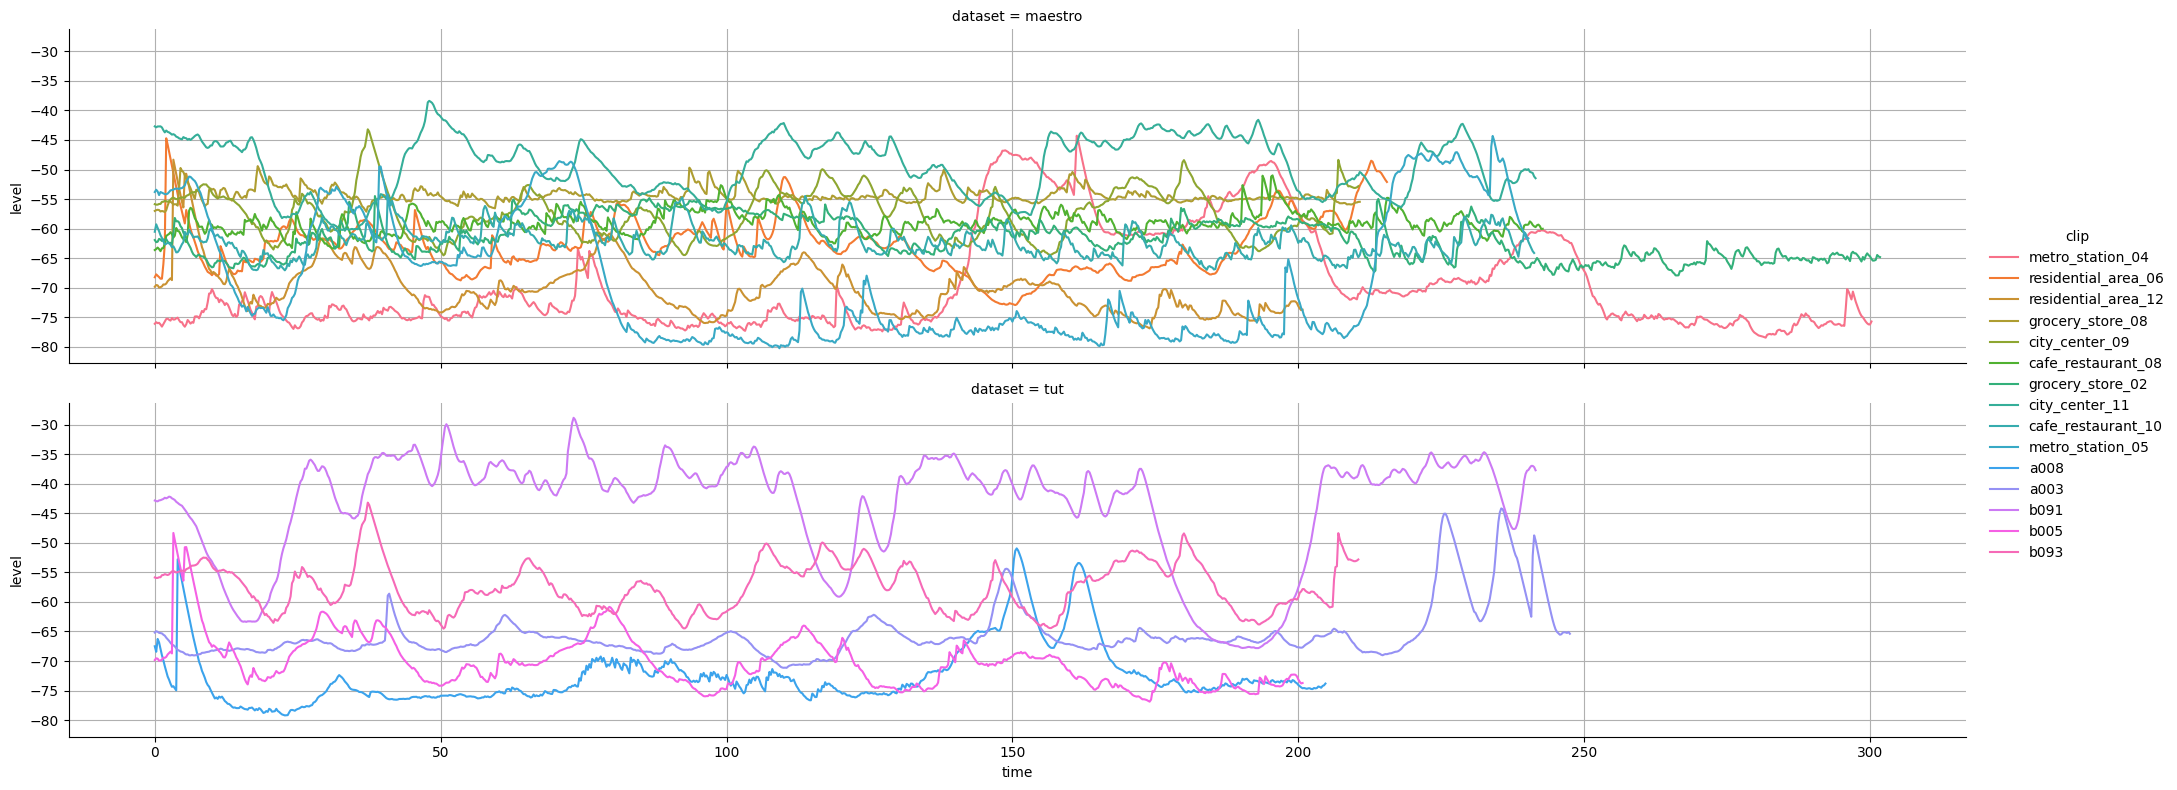

In [299]:

def plot_soundlevels(sl, value='level'):
    from matplotlib.ticker import MultipleLocator
    
    d = sl.reset_index()
    print(d.columns)
    d['time'] = d.time / pandas.Timedelta(seconds=1)
    
    g = seaborn.relplot(kind='line',
                        data=d,
                        x='time',
                        y=value,
                        hue='clip',
                        row='dataset',
                        aspect=5,
                        height=4)
    
    for ax in g.axes.flatten():
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.grid()
    
    return g

plot_soundlevels(soundlevels)
    


In [303]:
from src.features.soundlevel import compute_background

sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)
sb

/tmp/ipykernel_107770/4130781832.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)


level  background  \
config dataset clip             time                                            
LAS    maestro metro_station_04 0 days 00:00:00        -76.099976         NaN   
                                0 days 00:00:00.250000 -75.837673         NaN   
                                0 days 00:00:00.500000 -75.996588         NaN   
                                0 days 00:00:00.750000 -75.938581         NaN   
                                0 days 00:00:01        -76.228364         NaN   
...                                                           ...         ...   
       tut     b093             0 days 00:03:29.500000 -53.015915  -63.135142   
                                0 days 00:03:29.750000 -53.112149  -63.135142   
                                0 days 00:03:30        -53.103120  -63.135142   
                                0 days 00:03:30.250000 -53.007961  -63.135142   
                                0 days 00:03:30.500000 -52.817005  -63.135142   

                                                            delta  
config dataset clip             time                               
LAS    maestro metro_station_04 0 days 00:00:00               NaN  
                                0 days 00:00:00.250000        NaN  
                                0 days 00:00:00.500000        NaN  
                                0 days 00:00:00.750000        NaN  
                                0 days 00:00:01               NaN  
...                                                           ...  
       tut     b093             0 days 00:03:29.500000  10.119227  
                                0 days 00:03:29.750000  10.022993  
                                0 days 00:03:30         10.032022  
                                0 days 00:03:30.250000  10.127181  
                                0 days 00:03:30.500000  10.318137  

[14056 rows x 3 columns]

Index(['config', 'dataset', 'clip', 'time', 'level', 'background', 'delta'], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


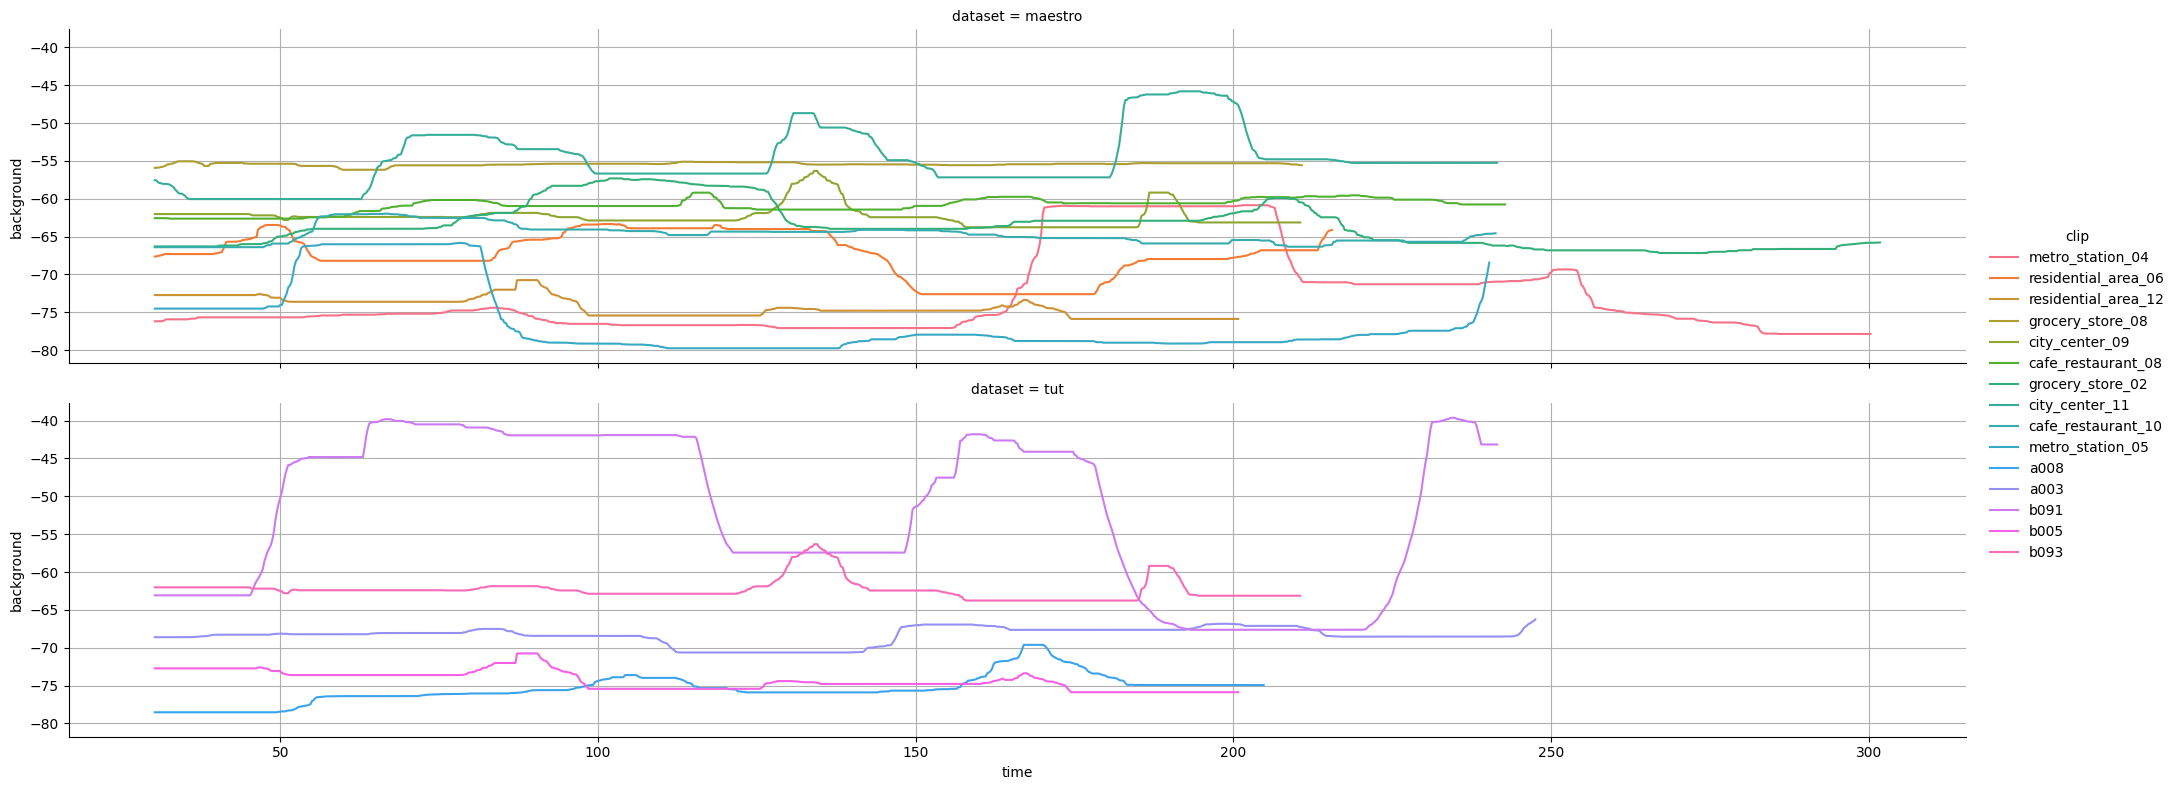

In [304]:
g = plot_soundlevels(sb, value='background')
g.savefig('soundlevels-background-maestro-tut-30s.png')

Index(['config', 'dataset', 'clip', 'time', 'level', 'background', 'delta'], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


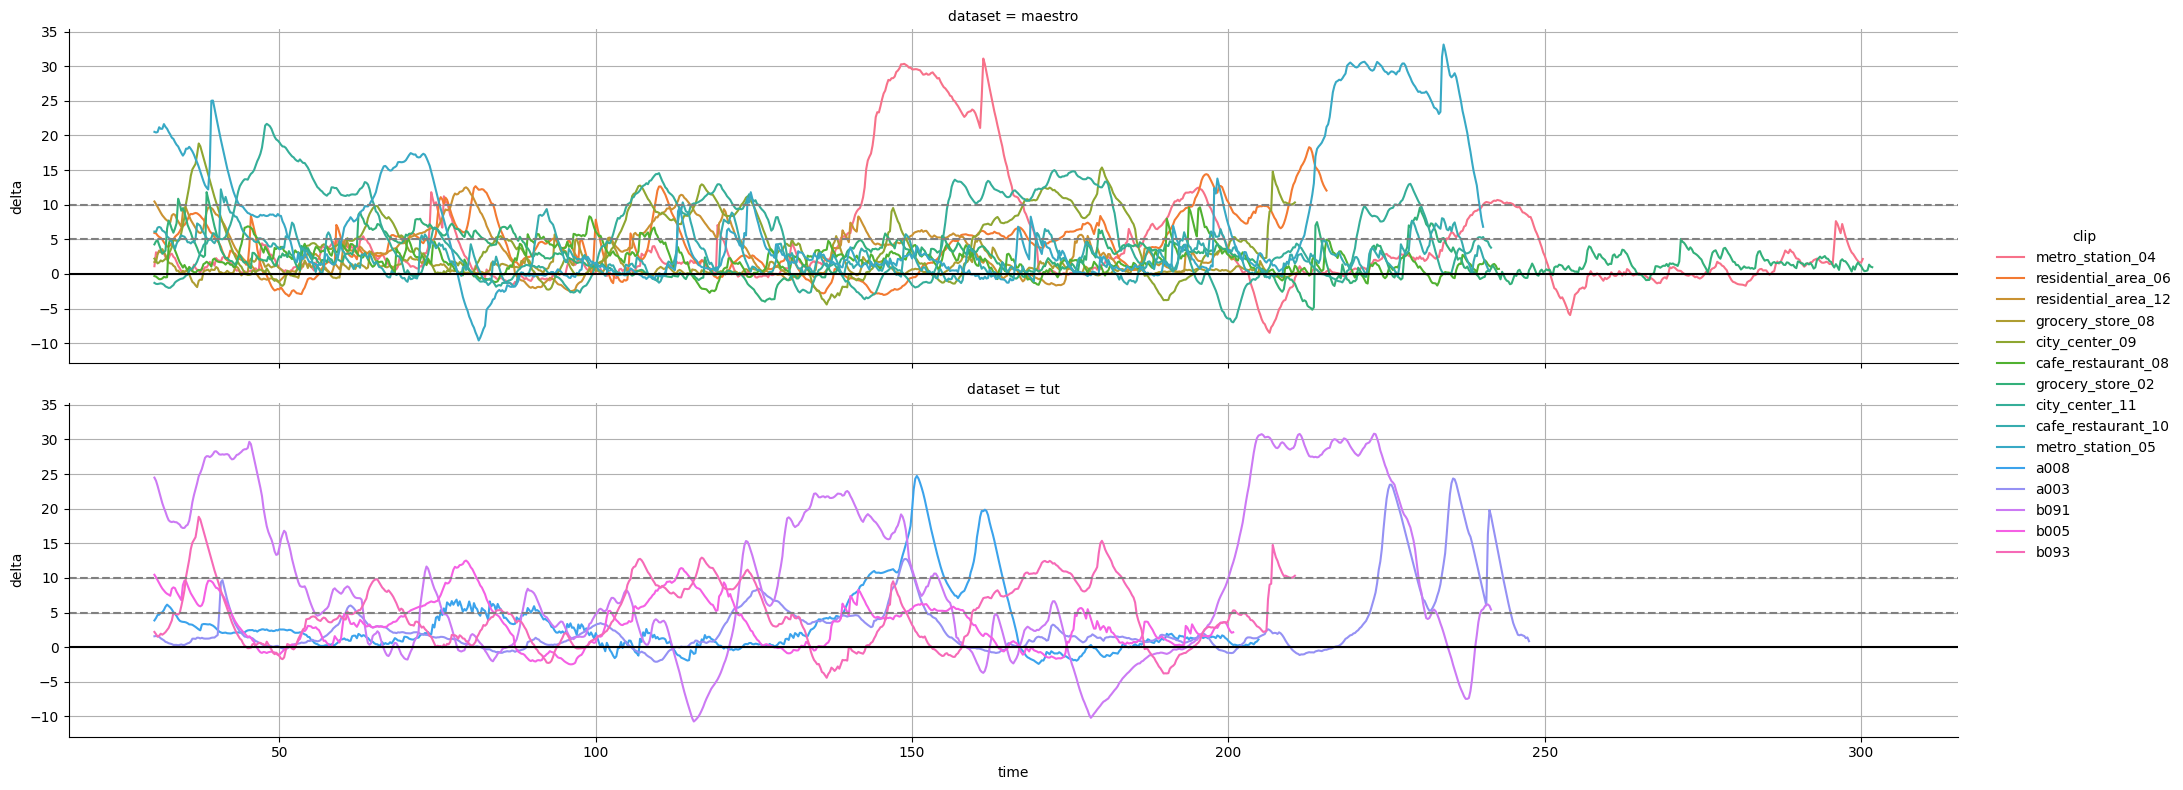

In [306]:
g = plot_soundlevels(sb, value='delta')
g.refline(y=0.0, ls='-', color='black')
g.refline(y=5.0, ls='--')
g.refline(y=10.0, ls='--')
g.savefig('soundlevels-eventdelta-maestro-tut-30s.png')

In [292]:
# Compute background/event data for different window lengths/durations
# NOTE: takes a couple of minutes
window_durations = numpy.arange(5.0, 60.0, 5.0)
window_results = {}

for dur in window_durations:
    sb = ss.groupby(['dataset', 'audio_name'], group_keys=False).dBA.apply(compute_background, window=dur)

    # confounding: the number of valid is influenced by window duration
    # Always cut first N=60 seconds to make it same across all cases
    sb = sb.reset_index()
    sb = sb[sb['time'] >= pandas.Timedelta(seconds=60.0)]
    window_results[dur] = sb


In [293]:
ddf = pandas.Series([df.set_index(['dataset', 'audio_name', 'time']) for df in window_results.values() ], index=window_results.keys(), name='duration')
ddf.index.name = 'window_duration'
flat = flatten_dataframes(ddf)
flat

outer_index ['window_duration']


level  \
window_duration dataset audio_name       time                                   
5.0             maestro metro_station_04 0 days 00:01:00.025804989 -66.126419   
                                         0 days 00:01:00.057052154 -65.186638   
                                         0 days 00:01:00.088299320 -65.459016   
                                         0 days 00:01:00.119546485 -65.478430   
                                         0 days 00:01:00.150793651 -66.242815   
...                                                                       ...   
55.0            tut     b093             0 days 00:03:30.699637188 -45.978123   
                                         0 days 00:03:30.730884354 -45.756233   
                                         0 days 00:03:30.762131519 -45.605983   
                                         0 days 00:03:30.793378685 -45.639681   
                                         0 days 00:03:30.824625850 -45.364127   

                                                                    background  \
window_duration dataset audio_name       time                                    
5.0             maestro metro_station_04 0 days 00:01:00.025804989  -71.254672   
                                         0 days 00:01:00.057052154  -71.225733   
                                         0 days 00:01:00.088299320  -71.001612   
                                         0 days 00:01:00.119546485  -70.888857   
                                         0 days 00:01:00.150793651  -70.614045   
...                                                                        ...   
55.0            tut     b093             0 days 00:03:30.699637188  -58.452256   
                                         0 days 00:03:30.730884354  -58.444171   
                                         0 days 00:03:30.762131519  -58.435552   
                                         0 days 00:03:30.793378685  -58.430861   
                                         0 days 00:03:30.824625850  -58.429583   

                                                                        delta  
window_duration dataset audio_name       time                                  
5.0             maestro metro_station_04 0 days 00:01:00.025804989   5.128253  
                                         0 days 00:01:00.057052154   6.039095  
                                         0 days 00:01:00.088299320   5.542597  
                                         0 days 00:01:00.119546485   5.410427  
                                         0 days 00:01:00.150793651   4.371230  
...                                                                       ...  
55.0            tut     b093             0 days 00:03:30.699637188  12.474133  
                                         0 days 00:03:30.730884354  12.687938  
                                         0 days 00:03:30.762131519  12.829569  
                                         0 days 00:03:30.793378685  12.791180  
                                         0 days 00:03:30.824625850  13.065456  

[920667 rows x 3 columns]

In [294]:

def summarize_background_and_events(soundlevels, event_threshold=5.0):
    """
    Quantify aspects of background/event separation   
    """
    # how background the the "background" is
    # how even it is. Ex: p10-p90 or p25-75 (IQR), or MAE

    # how eventy the events are...
    # number of events
    # duration of events. p10,p90,p50
    

    bg = soundlevels.background
    d = soundlevels.delta
    l = soundlevels.level

    e = soundlevels[soundlevels.delta > 5.0]

    s = pandas.Series({
        # originals
        'levels.L10': compute_ln(l, n=10),
        'levels.L90': compute_ln(l, n=90),
    
        # background
        'background.IQR': bg.quantile(0.75) - bg.quantile(0.25),
        #'background.MAE': ,

        'events.duration': len(e),
        'events.inv': len(soundlevels)-len(e),
    })
    return s

ss = flat.groupby(['window_duration', 'dataset', 'audio_name']).apply(summarize_background_and_events)
ss
    

levels.L10  levels.L90  \
window_duration dataset audio_name                                   
5.0             maestro cafe_restaurant_08  -52.851643  -58.482046   
                        cafe_restaurant_10  -55.475236  -63.543327   
                        city_center_09      -47.214770  -59.049777   
                        city_center_11      -38.279548  -51.283277   
                        grocery_store_02    -54.106639  -64.292332   
...                                                ...         ...   
55.0            tut     a003                -58.439524  -66.226186   
                        a008                -63.830559  -72.725555   
                        b005                -63.467559  -71.980101   
                        b091                -30.700959  -57.063997   
                        b093                -47.214770  -59.049777   

                                            background.IQR  events.duration  \
window_duration dataset audio_name                                            
5.0             maestro cafe_restaurant_08        1.264377            616.0   
                        cafe_restaurant_10        1.850092           1334.0   
                        city_center_09            6.268562            941.0   
                        city_center_11            6.492477           1186.0   
                        grocery_store_02          6.922960            626.0   
...                                                    ...              ...   
55.0            tut     a003                      2.260368           1244.0   
                        a008                      0.641771           1608.0   
                        b005                      1.133188            995.0   
                        b091                     16.882327           4037.0   
                        b093                      1.116198           2498.0   

                                            events.inv  
window_duration dataset audio_name                      
5.0             maestro cafe_restaurant_08      5247.0  
                        cafe_restaurant_10      4474.0  
                        city_center_09          3886.0  
                        city_center_11          4629.0  
                        grocery_store_02        7124.0  
...                                                ...  
55.0            tut     a003                    4770.0  
                        a008                    3035.0  
                        b005                    3520.0  
                        b091                    1785.0  
                        b093                    2329.0  

[165 rows x 5 columns]

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


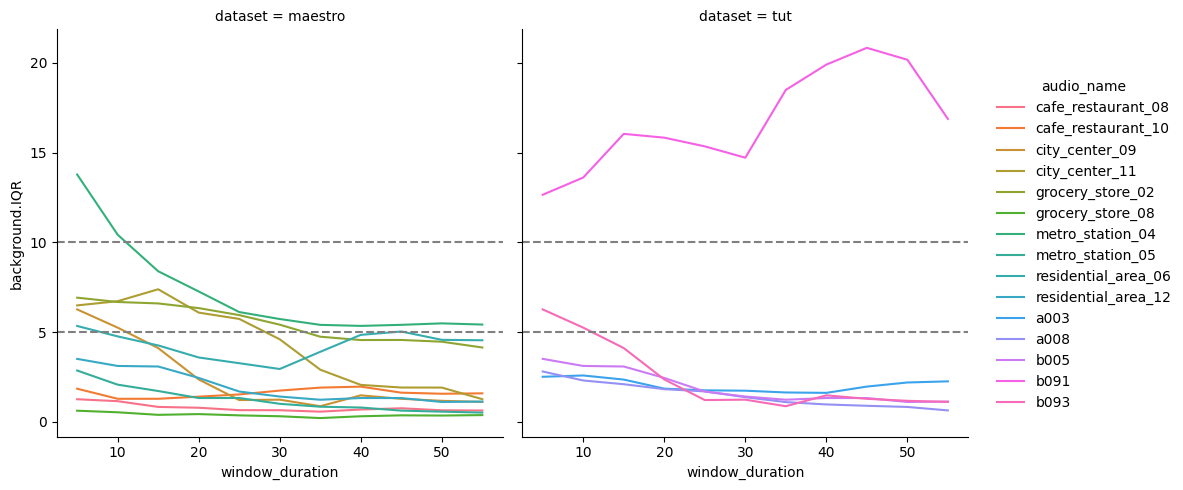

In [295]:

g = seaborn.relplot(kind='line', data=ss.reset_index(), col='dataset', hue='audio_name', x='window_duration', y='background.IQR')
g.refline(y=5.0)
g.refline(y=10.0)
g.savefig('background-vs-window-duration.png')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


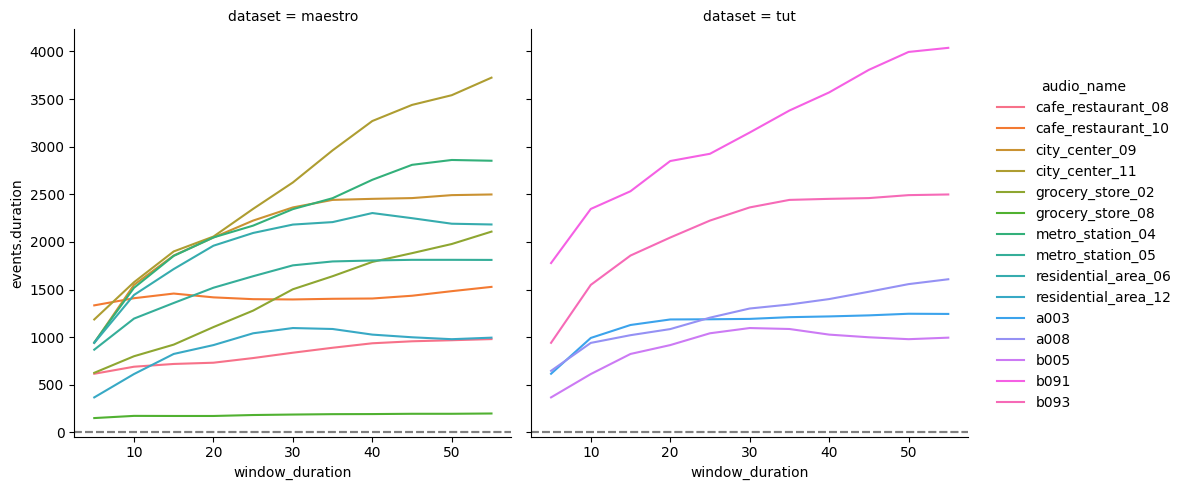

In [296]:

g = seaborn.relplot(kind='line', data=ss.reset_index(), col='dataset', hue='audio_name', x='window_duration', y='events.duration')
g.refline(y=5.0)
g.refline(y=10.0)
g.savefig('background-vs-window-duration-event-duration.png')


In [297]:

# longer seems better in both these cases. 
